<a href="https://colab.research.google.com/github/GafBof/GANs_torch/blob/cgan/03.%20Conditional%20GAN/cGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import random

import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch

import matplotlib.pyplot as plt

In [2]:
# Image processing
transform = transforms.ToTensor()

# MNIST dataset
mnist = datasets.MNIST(root='../data/',
                       train=True,
                       transform=transform,
                       download=True,)

# Data loader
dataloader = DataLoader(dataset=mnist,
                         batch_size=32, 
                         shuffle=True)

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw




Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [3]:
img_shape = (1, 28, 28)
latent_dim = 100

num_classes = 10

In [26]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.label_emb = nn.Embedding(num_classes, num_classes)

        self.model = nn.Sequential(
            nn.Linear(latent_dim + num_classes, 128),
            nn.LeakyReLU(0.2, True),

            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2, True),

            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2, True),

            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2, True),

            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )

    def forward(self, z, labels):
        z = torch.cat((self.label_emb(labels), z), -1)

        img = self.model(z)
        img = img.view(img.size(0), *img_shape)
        return img

In [27]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.label_emb = nn.Embedding(num_classes, num_classes)

        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)) + num_classes, 512),
            nn.LeakyReLU(0.2, True),

            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, True),

            nn.Linear(256, 128),
            nn.LeakyReLU(0.2, True),

            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, img, labels):
        img_flat = img.view(img.size(0), -1)
        data_in = torch.cat((self.label_emb(labels), img_flat), -1)
        validity = self.model(data_in)

        return validity

In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [29]:
# Loss function
adversarial_loss = torch.nn.BCELoss()

# Initialize generator and discriminator
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Epoch
num_epoch = 20

In [30]:
d_loss_arr = []
g_loss_arr = []

for epoch in range(num_epoch):
    for i, (imgs, labels) in enumerate(dataloader):

        # Adversarial ground truths
        valid = Variable(torch.FloatTensor(imgs.size(0), 1).fill_(0.9), requires_grad=False).to(device)
        fake = Variable(torch.FloatTensor(imgs.size(0), 1).fill_(0.0), requires_grad=False).to(device)

        # Configure input
        real_imgs = Variable(imgs.type(torch.FloatTensor)).to(device)
        labels = labels.to(device)

        #  Train Generator
        optimizer_G.zero_grad()

        # Sample noise as generator input
        z = Variable(torch.FloatTensor(np.random.normal(0, 1, (imgs.shape[0], latent_dim)))).to(device)
        gen_labels = Variable(torch.LongTensor(np.random.randint(0, num_classes, imgs.shape[0]))).to(device)

        # Generate a batch of images
        gen_imgs = generator(z, gen_labels)

        # Loss measures generator's ability to fool the discriminator
        g_loss = adversarial_loss(discriminator(gen_imgs, gen_labels), valid)

        g_loss.backward()
        optimizer_G.step()

        #  Train Discriminator
        optimizer_D.zero_grad()

        # Measure discriminator's ability to classify real from generated samples
        real_loss = adversarial_loss(discriminator(real_imgs, labels), valid)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach(), gen_labels), fake)
        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()

    # Save loss
    d_loss_arr.append(d_loss.item())
    g_loss_arr.append(g_loss.item())

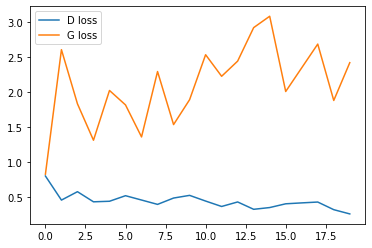

In [31]:
# Plot loss of Generator and Discriminator

plt.plot(d_loss_arr, label="D loss")
plt.plot(g_loss_arr, label="G loss")

plt.legend()
plt.show()

In [32]:
# Generate image from Generator block

z = Variable(torch.FloatTensor(np.random.normal(0, 1, (50, latent_dim)))).to(device)
labels = Variable(torch.LongTensor([i for i in range(10)] * 5)).to(device)

# Generate a batch of images
gen_imgs = generator(z, labels).detach().cpu().numpy()

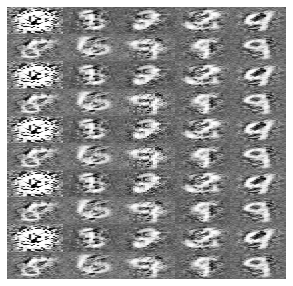

In [33]:
# Plot the result

plt.figure(figsize=(5,5))

for i in range(50):
    plt.subplot(10, 5, i + 1)
    plt.axis("off")
    plt.imshow(gen_imgs[i][0], aspect='auto', cmap='gray')

plt.subplots_adjust(hspace=0, wspace=0)
plt.show()

In [ ]:
plt.imshow(gen_imgs[0][0], aspect='auto', cmap='gray')